In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,train_test_split,cross_val_score,learning_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

In [ ]:
import multiprocessing
num_workers = multiprocessing.cpu_count()
print(f"Number of available workers: {num_workers}")

Number of available workers: 2


In [ ]:
df = pd.read_csv("Train_data.csv")
df = df.dropna()  # must do
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30798 entries, 0 to 31042
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LATITUDE     30798 non-null  float64
 1   LONGITUDE    30798 non-null  float64
 2   CTDPRS       30798 non-null  float64
 3   CTDTMP       30798 non-null  float64
 4   CTDSAL       30798 non-null  float64
 5   depth_m      30798 non-null  float64
 6   SA           30798 non-null  float64
 7   CT           30798 non-null  float64
 8   sound_speed  30798 non-null  float64
dtypes: float64(9)
memory usage: 2.3 MB


In [ ]:
X = df.drop(columns=["sound_speed"])
y = df.sound_speed
print(X.shape,y.shape)

(30798, 8) (30798,)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True,random_state=42,test_size=0.2)
X_train.shape,y_test.shape

((24638, 8), (6160,))

In [ ]:
KNN_pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('knn',KNeighborsRegressor(n_neighbors=2,n_jobs=-1))
])

In [ ]:
cv_scores = cross_val_score(KNN_pipeline,X_train,y_train,cv=5,scoring="neg_mean_squared_error")
KNN_pipeline.fit(X_train,y_train)
y_pred = KNN_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
r2 = r2_score(y_test,y_pred)
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 1.5004477421789186
R2: 0.9963105031744794


In [ ]:
import joblib
modelfile = "KNN_model.joblib"
joblib.dump(KNN_pipeline,modelfile)

['KNN_model.joblib']

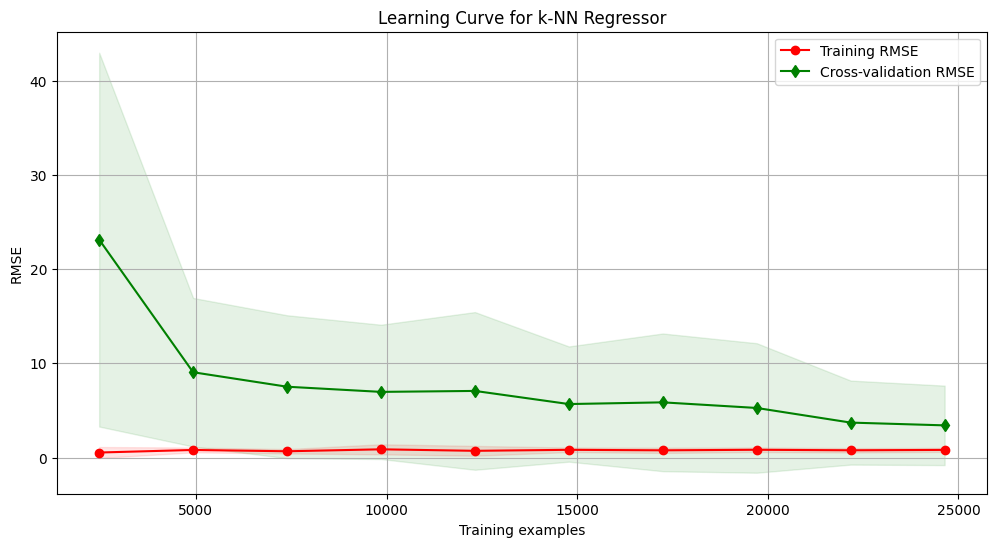

In [ ]:
# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    KNN_pipeline, X, y,
    train_sizes=np.linspace(0.1, 1.0, 10), cv=5,
    scoring='neg_mean_squared_error', n_jobs=-1
)

train_rmse_mean = np.sqrt(-np.mean(train_scores, axis=1))
train_rmse_std = np.sqrt(np.std(train_scores, axis=1))
test_rmse_mean = np.sqrt(-np.mean(test_scores, axis=1))
test_rmse_std = np.sqrt(np.std(test_scores, axis=1))

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_rmse_mean, 'o-', color="r", label="Training RMSE")
plt.plot(train_sizes, test_rmse_mean, 'd-', color="g", label="Cross-validation RMSE")

plt.fill_between(train_sizes, train_rmse_mean - train_rmse_std, train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_rmse_mean - test_rmse_std, test_rmse_mean + test_rmse_std, alpha=0.1, color="g")

plt.title('Learning Curve for k-NN Regressor')
plt.xlabel('Training examples')
plt.ylabel('RMSE')
plt.legend(loc="best")
plt.grid()
# plt.savefig('../PaperPlot/lc_knn.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
def calculate_metrics(x, y):
    # 1. RMSE
    rmse = np.sqrt(mean_squared_error(x, y))

    # 2. R^2
    r2 = r2_score(x, y)

    # 3. Pearson correlation coefficient (r) and 95% confidence interval
    r, _ = stats.pearsonr(x, y)

    # Compute the confidence interval for Pearson correlation coefficient
    conf_coeff = 1.96 * np.sqrt((1 - r**2) / (len(x) - 2))
    conf_interval = (r - conf_coeff, r + conf_coeff)

    return rmse, r2, r, conf_interval

# Test
x_sample = y_test
y_sample = y_pred
rmse, r2, r, conf_interval = calculate_metrics(x_sample, y_sample)

print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"Pearson correlation coefficient (r): {r:.4f}")
print(f"95% confidence interval for Pearson's r: ({conf_interval[0]:.4f}, {conf_interval[1]:.4f})")

RMSE: 1.5004
R^2: 0.9963
Pearson correlation coefficient (r): 0.9982
95% confidence interval for Pearson's r: (0.9966, 0.9997)


In [ ]:
Y_pred = KNN_pipeline.predict(X)

In [ ]:
# for whole
x_sample = y
y_sample = Y_pred
rmse, r2, r, conf_interval = calculate_metrics(x_sample, y_sample)

print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"Pearson correlation coefficient (r): {r:.4f}")
print(f"95% confidence interval for Pearson's r: ({conf_interval[0]:.4f}, {conf_interval[1]:.4f})")

RMSE: 1.0145
R^2: 0.9983
Pearson correlation coefficient (r): 0.9992
95% confidence interval for Pearson's r: (0.9987, 0.9996)


In [ ]:
dpred = pd.read_csv("Predicted_Speed.csv")
dpred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30798 entries, 0 to 30797
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          30798 non-null  int64  
 1   LATITUDE            30798 non-null  float64
 2   LONGITUDE           30798 non-null  float64
 3   Actual_Sound_Speed  30798 non-null  float64
 4   DNN                 30798 non-null  float64
 5   KNN                 30798 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 1.4 MB


In [ ]:
dpred = dpred.rename(columns={'Predicted_Sound_Speed':'DNN'})
dpred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30798 entries, 0 to 30797
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LATITUDE            30798 non-null  float64
 1   LONGITUDE           30798 non-null  float64
 2   Actual_Sound_Speed  30798 non-null  float64
 3   DNN                 30798 non-null  float64
dtypes: float64(4)
memory usage: 962.6 KB


In [ ]:
dy = pd.DataFrame(Y_pred,columns=['KNN'])
dy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30798 entries, 0 to 30797
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KNN     30798 non-null  float64
dtypes: float64(1)
memory usage: 240.7 KB


In [ ]:
full = pd.concat(
    [dpred,dy],axis=1
)
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30798 entries, 0 to 30797
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LATITUDE            30798 non-null  float64
 1   LONGITUDE           30798 non-null  float64
 2   Actual_Sound_Speed  30798 non-null  float64
 3   DNN                 30798 non-null  float64
 4   KNN                 30798 non-null  float64
dtypes: float64(5)
memory usage: 1.2 MB


In [ ]:
full.head()

,LATITUDE,LONGITUDE,Actual_Sound_Speed,DNN,KNN
0,-2.3390,141.1528,1496.1240,1495.4421,1496.004279
1,-2.2497,141.2340,1497.3676,1496.2847,1497.346537
2,-2.1690,141.4777,1502.3992,1500.7690,1502.243966
3,-2.0842,141.7432,1499.1193,1497.9097,1499.115617
4,-2.0038,141.9930,1499.7203,1498.4882,1499.659480


In [ ]:
path = "Predicted_Speed.csv"
full.to_csv(path)

## Processing .NCs

In [7]:
!wget https://www.ncei.noaa.gov/data/oceans/woa/WOA18/DATA/temperature/csv/decav/1.00/woa18_decav_t03mn01.csv.gz


--2025-10-24 12:03:12--  https://www.ncei.noaa.gov/data/oceans/woa/WOA18/DATA/temperature/csv/decav/1.00/woa18_decav_t03mn01.csv.gz
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 205.167.25.171, 205.167.25.177, 205.167.25.172, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|205.167.25.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4375419 (4.2M) [application/gzip]
Saving to: ‘woa18_decav_t03mn01.csv.gz’

woa18_decav_t03mn01 100%[===================>]   4.17M  --.-KB/s    in 0.1s    

2025-10-24 12:03:12 (30.0 MB/s) - ‘woa18_decav_t03mn01.csv.gz’ saved [4375419/4375419]



In [8]:
!wget https://www.ncei.noaa.gov/data/oceans/woa/WOA18/DATA/salinity/csv/decav/1.00/woa18_decav_s03mn01.csv.gz


--2025-10-24 12:03:27--  https://www.ncei.noaa.gov/data/oceans/woa/WOA18/DATA/salinity/csv/decav/1.00/woa18_decav_s03mn01.csv.gz
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 205.167.25.171, 205.167.25.177, 205.167.25.172, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|205.167.25.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3043097 (2.9M) [application/gzip]
Saving to: ‘woa18_decav_s03mn01.csv.gz’

woa18_decav_s03mn01 100%[===================>]   2.90M  --.-KB/s    in 0.1s    

2025-10-24 12:03:27 (23.6 MB/s) - ‘woa18_decav_s03mn01.csv.gz’ saved [3043097/3043097]



In [10]:
!gunzip /content/woa18_decav_s03mn01.csv.gz
!gunzip /content/woa18_decav_t03mn01.csv.gz

In [ ]:
import pandas as pd

In [19]:
df = pd.read_csv("/content/woa18_decav_s03mn01.csv", compression=None,low_memory=False)  # header(s) present
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31970 entries, ('#COMMA SEPARATED LATITUDE', ' LONGITUDE', ' AND VALUES AT DEPTHS (M):0', np.float64(5.0), np.float64(10.0), np.float64(15.0), np.float64(20.0), np.float64(25.0), np.float64(30.0), np.float64(35.0), np.float64(40.0), np.float64(45.0), np.float64(50.0), np.float64(55.0), np.float64(60.0), np.float64(65.0), np.float64(70.0), np.float64(75.0), np.float64(80.0), np.float64(85.0), np.float64(90.0), np.float64(95.0), np.float64(100.0), np.float64(125.0), np.float64(150.0), np.float64(175.0), np.float64(200.0), np.float64(225.0), np.float64(250.0), np.float64(275.0), np.float64(300.0), np.float64(325.0), np.float64(350.0), np.float64(375.0), np.float64(400.0), np.float64(425.0), np.float64(450.0), np.float64(475.0), np.float64(500.0), np.float64(550.0), np.float64(600.0), np.float64(650.0), np.float64(700.0), np.float64(750.0), np.float64(800.0), np.float64(850.0), np.float64(900.0), np.float64(950.0), np.float64(1000.0), np.fl

In [18]:
df.isna().sum().sum(),df.isnull().sum().sum()

(np.int64(7483), np.int64(7483))